## Using statistical tests to select features for building a linear regression model

* Statistical tests can be used to select those features that have the strongest relationship with the output variable.

* It can be seen as a preprocessing step to an estimator. 

In [1]:
import pandas as pd
import pylab
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Load and preprocess Data

In [2]:
housesale_df = pd.read_csv('datasets/housesale.csv', dtype = 'float')

In [3]:
housesale_df.shape

(21597, 18)

In [4]:
housesale_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,age,renovated
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,47.5112,-122.257,1340.0,5650.0,63.0,0.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,47.7210,-122.319,1690.0,7639.0,67.0,1.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,47.7379,-122.233,2720.0,8062.0,85.0,0.0
3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,47.5208,-122.393,1360.0,5000.0,53.0,0.0
4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,47.6168,-122.045,1800.0,7503.0,31.0,0.0


In [5]:
X = housesale_df.drop('price', axis = 1)
y = housesale_df['price']

X.shape

(21597, 17)

## Feature Selection : f_regression
* f_regression : Linear model for testing the individual effect of each of many regressors. Based on ANOVA.

* SelectKBest A feature selection method from sklearn that can be used with a suite of different statistical tests to select a specific number of features. Uses f-score computed using ANOVA to select k best features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [6]:
from sklearn.feature_selection import f_regression, SelectKBest

select_features = SelectKBest(f_regression, k = 3)

In [7]:
X_new = select_features.fit_transform(X, y)

In [8]:
X_new.shape

(21597, 3)

In [9]:
X_new = pd.DataFrame(X_new)

X_new.head()

,0,1,2
0,1180.0,7.0,1180.0
1,2570.0,7.0,2170.0
2,770.0,6.0,770.0
3,1960.0,7.0,1050.0
4,1680.0,8.0,1680.0


In [10]:
selected_features = []

for i in range(len(X_new.columns)):
    for j in range(len(X.columns)):
        if(X_new.iloc[:,i].equals( X.iloc[:,j])):
            selected_features.append(X.columns[j])
            
selected_features

['sqft_living', 'grade', 'sqft_above']

In [11]:
rejected_features = set(list(X)) - set(selected_features)

rejected_features

{'age',
 'bathrooms',
 'bedrooms',
 'condition',
 'floors',
 'lat',
 'long',
 'renovated',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'waterfront'}

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2)

In [13]:
x_train.shape, y_train.shape

((17277, 3), (17277,))

In [14]:
x_test.shape, y_test.shape

((4320, 3), (4320,))

In [15]:
model = sm.OLS(y_train, x_train)

In [16]:
result = model.fit()

In [17]:
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                          3.110e+04
Date:                Tue, 11 May 2021   Prob (F-statistic):                        0.00
Time:                        14:17:49   Log-Likelihood:                     -2.3968e+05
No. Observations:               17277   AIC:                                  4.794e+05
Df Residuals:                   17274   BIC:                                  4.794e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [18]:
y_pred = result.predict(x_test)

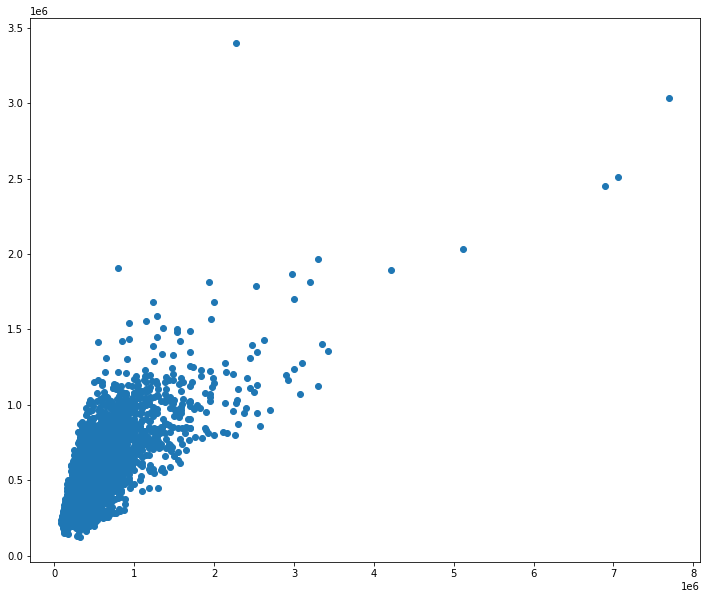

In [19]:
plt.figure(figsize = (12,10))

plt.scatter(y_test.values, y_pred)

plt.show()

# Hyperparameter Tuning

In [20]:
FEATURES = list(housesale_df.columns[1:18])

FEATURES

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'age',
 'renovated']

In [21]:
def build_model(regression_fn,                
                target, 
                features, 
                dataset,
                preprocess_fn,
                *hyperparameters):
    
    X = dataset[features]
    Y = dataset[target]

    X = preprocess_fn(X, Y, *hyperparameters)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    model = regression_fn(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    return {
            'x_train' : x_train,
            'x_test'  : x_test, 
            'y_train' : y_train,
            'y_test'  : y_test,
            'y_pred'  : y_pred,
            'model'   : model
           }     

In [22]:
def compare_results(result_dict):
    
    for key in result_dict:
        print('Test : ', key)
        print('R-Squared', result_dict[key]['rsquared'])
        print('Adjusted R-Squared', result_dict[key]['adj_rsquared'])
        print()
        
    n_components = list(range(1, 18))
    reg_score = [result_dict[key]['adj_rsquared'] for key in result_dict]

    plt.figure(figsize = (12, 10))
    plt.plot(n_components, reg_score)

    pylab.ylim([0,1])
    
    plt.xlabel('n components')
    plt.ylabel('adj_rsquared');

In [23]:
def get_model_scores(model_params):
    
    result_dict = {}

    for key in model_params:
        result_dict[key] = {
                            'rsquared' : model_params[key]['model'].rsquared,
                            'adj_rsquared': model_params[key]['model'].rsquared_adj
                           }
        
    compare_results(result_dict)

In [24]:
def ols_reg(x_train, y_train):
    
    ols = sm.OLS(y_train, x_train)
    
    model = ols.fit()
    
    return model

In [25]:
from sklearn.feature_selection import f_regression, SelectKBest

def apply_f_regression(x, y, k, add_constant = False):
    
    select_features = SelectKBest(f_regression, k = k)
    x_new = select_features.fit_transform(x, y)
    
    if add_constant is True:
        x_new = sm.add_constant(x_new)
        
    return pd.DataFrame(x_new)

In [26]:
model_params = {}

for i in range (1, 18):
    model_params['f_regression - k:' + str(i)] = build_model(ols_reg,
                                                             'price',
                                                              FEATURES,
                                                              housesale_df,
                                                              apply_f_regression,
                                                              i,
                                                              True)

Test :  f_regression - k:1
R-Squared 0.49368738368367604
Adjusted R-Squared 0.49365807470443923

Test :  f_regression - k:2
R-Squared 0.5337652575605
Adjusted R-Squared 0.5337112764626142

Test :  f_regression - k:3
R-Squared 0.5422922001228613
Adjusted R-Squared 0.5422127047601778

Test :  f_regression - k:4
R-Squared 0.5414420875097539
Adjusted R-Squared 0.5413358906796264

Test :  f_regression - k:5
R-Squared 0.5476448257235446
Adjusted R-Squared 0.5475138677088736

Test :  f_regression - k:6
R-Squared 0.5738782100322277
Adjusted R-Squared 0.5737301654034028

Test :  f_regression - k:7
R-Squared 0.5765819510503347
Adjusted R-Squared 0.5764348457640754

Test :  f_regression - k:8
R-Squared 0.5810151202618394
Adjusted R-Squared 0.5808452844775921

Test :  f_regression - k:9
R-Squared 0.6413518373628727
Adjusted R-Squared 0.6411856811605854

Test :  f_regression - k:10
R-Squared 0.6543230952832904
Adjusted R-Squared 0.6541429196799748

Test :  f_regression - k:11
R-Squared 0.6564228074

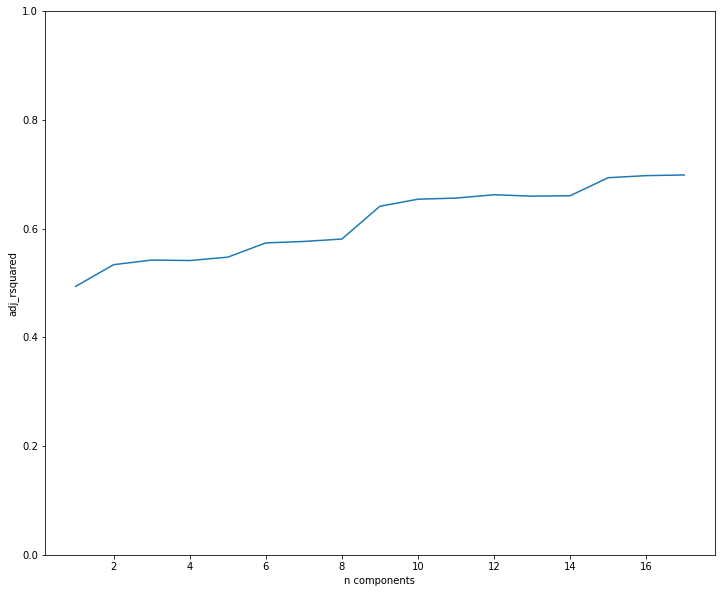

In [27]:
get_model_scores(model_params)

# Sklearn Regression Model

In [28]:
def linear_reg(x_train, y_train):
    
    model = LinearRegression().fit(x_train, y_train)
    
    return model

In [29]:
sklearn_model = {}

sklearn_model['f_regression'] = build_model(linear_reg,
                                          'price',
                                           FEATURES,
                                           housesale_df,
                                           apply_f_regression,
                                           9)

### Evaluate Model

In [30]:
model   = sklearn_model['f_regression']['model']
x_train = sklearn_model['f_regression']['x_train']
x_test  = sklearn_model['f_regression']['x_test']
y_train = sklearn_model['f_regression']['y_train']
y_test  = sklearn_model['f_regression']['y_test']
y_pred  = sklearn_model['f_regression']['y_pred']

In [31]:
print('Training score: ', model.score(x_train, y_train))
print('Testing score: ', r2_score(y_test, y_pred))

Training score:  0.6426566257525651
Testing score:  0.6298447814999404


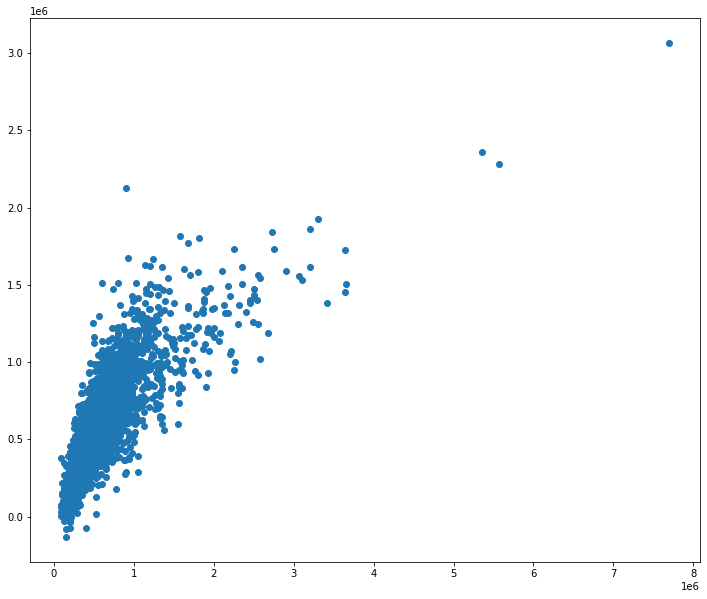

In [32]:
plt.figure(figsize = (12, 10))

plt.scatter(y_test.values, y_pred)

plt.show()

## Feature Selection : mutual_info_regression
*  mutual_info_regression : Estimate mutual information for a continuous target variable.
* Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. 
* It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression

In [33]:
from sklearn.feature_selection import mutual_info_regression

def apply_mutual_info_regression(x, y, k, add_constant = False):
    
    select_features = SelectKBest(mutual_info_regression, k = k)  
    x_new = select_features.fit_transform(x, y)
    
    if add_constant is True: 
        x_new = sm.add_constant(x_new)

    return pd.DataFrame(x_new)

In [34]:
model_params = {}

for i in range (1, 18):
    model_params['mutual_info_regression - k:' + str(i)] = build_model(ols_reg,
                                                                      'price',
                                                                       FEATURES,
                                                                       housesale_df,
                                                                       apply_mutual_info_regression,
                                                                       i,
                                                                       True)

Test :  mutual_info_regression - k:1
R-Squared 0.49256088657647923
Adjusted R-Squared 0.492531512387569

Test :  mutual_info_regression - k:2
R-Squared 0.5285979906641343
Adjusted R-Squared 0.5285434112952173

Test :  mutual_info_regression - k:3
R-Squared 0.5940129065571479
Adjusted R-Squared 0.5939423941226936

Test :  mutual_info_regression - k:4
R-Squared 0.6000872015288052
Adjusted R-Squared 0.5999945862443051

Test :  mutual_info_regression - k:5
R-Squared 0.6013533194121077
Adjusted R-Squared 0.6012379101478531

Test :  mutual_info_regression - k:6
R-Squared 0.6005316463514205
Adjusted R-Squared 0.6003928617467946

Test :  mutual_info_regression - k:7
R-Squared 0.6188382059649542
Adjusted R-Squared 0.6186837017922606

Test :  mutual_info_regression - k:8
R-Squared 0.6198936255040342
Adjusted R-Squared 0.6197175280407513

Test :  mutual_info_regression - k:9
R-Squared 0.6192616060312075
Adjusted R-Squared 0.6190631554870645

Test :  mutual_info_regression - k:10
R-Squared 0.62073

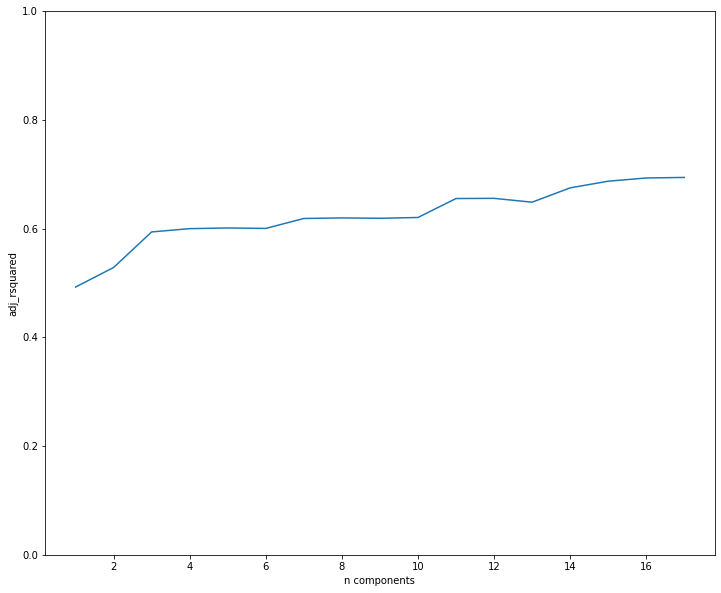

In [35]:
get_model_scores(model_params)

# Sklearn Regression Model

In [36]:
sklearn_model = {}

sklearn_model['mutual_info_regression'] = build_model(linear_reg,
                                                      'price',
                                                       FEATURES,
                                                       housesale_df,
                                                       apply_mutual_info_regression,
                                                       4)

### Evaluate Model

In [37]:
model   = sklearn_model['mutual_info_regression']['model']
x_train = sklearn_model['mutual_info_regression']['x_train']
x_test  = sklearn_model['mutual_info_regression']['x_test']
y_train = sklearn_model['mutual_info_regression']['y_train']
y_test  = sklearn_model['mutual_info_regression']['y_test']
y_pred  = sklearn_model['mutual_info_regression']['y_pred']

In [38]:
print('Training score: ', model.score(x_train, y_train))
print('Testing score: ', r2_score(y_test, y_pred))

Training score:  0.5989455026549473
Testing score:  0.5883925962469405


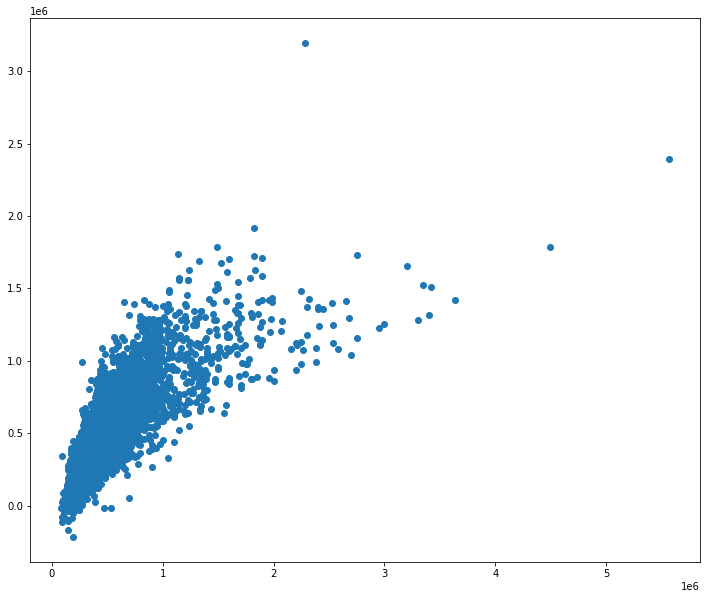

In [39]:
plt.figure(figsize = (12, 10))

plt.scatter(y_test.values, y_pred)

plt.show()

In [40]:
import pytorch

ModuleNotFoundError: No module named 'pytorch'

In [ ]:
!conda install pytorch torchvision torchaudio -c pytorch -y